# Exploring model weights

The weights the model learns indicates patterns of gene expression activations present across tumors. In an unsupervised model, these weights learned can point to known biology, unknown biology, or unrelated noise. One of the benefits of a variational autoencoder, is that the weights learned that represent each encoding are independent and nonlinear. Therefore, they can extract out signal representative of noise while still retaining relevant known and unknown biology.

Here we explore specific signals that should be present in the data - signals representing the sex of the patient, and metastatic tumor activation patterns.

In [1]:
import os
import pandas as pd
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":10,"axes.labelsize":15})   

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

Because of the complex architecture involved in encoding the data, we will use the `decoded` weights to describe feature encoding specific activation patterns

In [4]:
# Load the decoder model
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')
decoder = load_model(decoder_model_file)

/home/gway/anaconda3/lib/python3.5/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# Extract the weights
decoded_weights = []
for layer in decoder.layers:
    decoded_weights.append(layer.get_weights())

In [6]:
# For a future pathway analysis, the background genes to consider is important
# Also needed to set column names on weights
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

pd.DataFrame(rnaseq_df.columns).to_csv(os.path.join('results', 'background_genes.txt'), sep='\t')

(10459, 5000)


In [7]:
node_weights = pd.DataFrame(decoded_weights[1][0], columns=rnaseq_df.columns, index=range(1, 101))
node_weights.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
1,-0.038720,0.016661,0.029607,0.039584,-0.001849,0.012594,0.016473,0.012619,-0.041976,-0.035155,...,0.015413,-0.021422,-0.009609,-0.016911,0.001458,-0.014941,-0.008457,-0.028340,-0.004947,0.014693
2,-0.038551,0.025872,0.026606,0.014903,0.011040,-0.018997,0.002153,-0.003017,-0.042659,-0.044308,...,-0.007668,0.000821,0.020055,0.012365,0.010221,0.010597,-0.018201,0.031298,-0.014771,-0.012871
3,-0.057145,0.049043,-0.015987,0.045061,0.059522,-0.004063,-0.019257,0.047825,-0.062008,-0.056080,...,0.008841,-0.020431,-0.002847,0.006580,-0.011175,0.011523,-0.012128,-0.030821,-0.021505,-0.001221
4,0.004954,-0.004809,-0.044762,-0.012932,-0.009277,-0.051595,-0.019978,-0.023743,0.007448,0.006688,...,0.023057,0.008616,-0.007181,-0.018091,-0.024505,-0.011072,0.006214,-0.018380,-0.019916,0.013352
5,-0.010185,-0.019890,-0.030277,0.000779,0.043571,-0.019086,-0.035159,0.023559,-0.000984,-0.002832,...,0.000954,-0.021331,-0.013653,0.035008,-0.026382,0.015444,0.015401,-0.028368,-0.026241,-0.023642


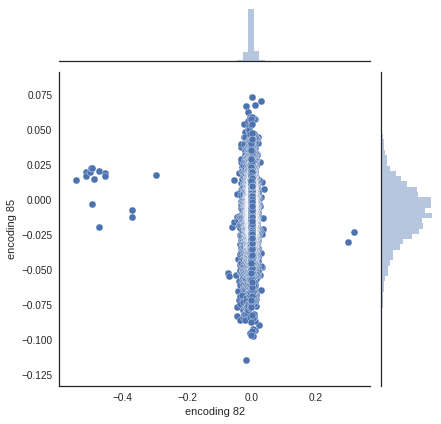

In [8]:
# We previously identified node 82 as robustly separating sex in the data set:
# Visualize the distribution of gene weights here
sex_node = node_weights.loc[82, :]
sex_node_plot = node_weights.loc[[82, 85], :]
sex_node_plot = sex_node_plot.T
sex_node_plot.columns = ['encoding 82', 'encoding 85']
sex_node_plot = sex_node_plot.reindex(sex_node_plot['encoding 82'].abs().sort_values(ascending=False).index)
g = sns.jointplot(x='encoding 82', y='encoding 85', data=sex_node_plot,
                  edgecolor="w", stat_func=None);

In [9]:
sex_node_plot.head(17)

,encoding 82,encoding 85
EIF1AY,-0.543605,0.013644
UTY,-0.514367,0.019198
CYorf15A,-0.514013,0.016753
KDM5D,-0.499488,0.019061
DDX3Y,-0.497709,0.022053
TMSB4Y,-0.495302,-0.003714
USP9Y,-0.494874,0.022164
TTTY15,-0.487078,0.014047
NCRNA00185,-0.473645,-0.019878
CYorf15B,-0.472546,0.019967


By measuring expression of only *17 genes*, we can reliably predict the sex of the cancer patient. These are genes most expressed by sex chromosomes including x inactivating genes _XIST_ and _TSIX_.

In [10]:
# Save outputs
sex_node_plot_file = os.path.join('figures', 'sex_node_gene_scatter.pdf')
sex_node_gene_file = os.path.join('results', 'sex_node_activated_genes.tsv')
g.savefig(sex_node_plot_file)
sex_node_plot.to_csv(sex_node_gene_file, sep='\t')

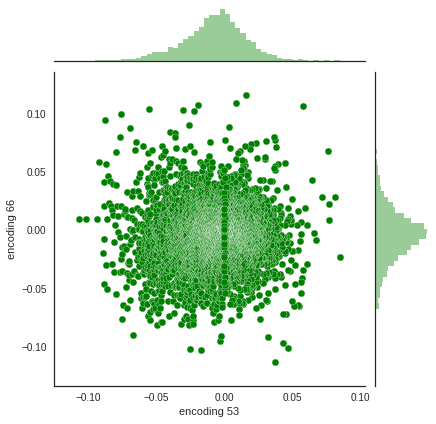

In [11]:
# We previously observed metastasis samples being robustly separated by two features
# Visualize the feature scores here
met_node_plot = node_weights.loc[[53, 66], :]
met_node_plot = met_node_plot.T
met_node_plot.columns = ['encoding 53', 'encoding 66']
met_node_plot = met_node_plot.reindex(met_node_plot['encoding 53'].abs().sort_values(ascending=False).index)
g = sns.jointplot(x='encoding 53', y='encoding 66', data=met_node_plot,
                  color='green', edgecolor="w", stat_func=None);

In [12]:
# Save outputs
met_node_plot_file = os.path.join('figures', 'skcm_metastasis_node_gene_scatter.pdf')
met_node_gene_file = os.path.join('results', 'skcm_metastasis_node_activated_genes.tsv')
g.savefig(met_node_plot_file)
met_node_plot.to_csv(met_node_gene_file, sep='\t')

Because the genes involved in these nodes are not as cut and dry as the sex specific nodes, perform a pathway analysis on the high weight genes explaining each tail of node 53 and 66

In [13]:
encoding66 = (
    met_node_plot
    .reindex(met_node_plot['encoding 66'].abs()
             .sort_values(ascending=False).index)['encoding 66']
    )

high_weight_pos = encoding66[encoding66 > encoding66.std() * 2.5]
high_weight_neg = encoding66[encoding66 < -encoding66.std() * 2.5]

high_weight_pos.to_csv(os.path.join('results', 'hightweightpos_genes_node66.tsv'), sep='\t')
high_weight_neg.to_csv(os.path.join('results', 'hightweightneg_genes_node66.tsv'), sep='\t')

In [14]:
encoding53 = (
    met_node_plot
    .reindex(met_node_plot['encoding 53'].abs()
             .sort_values(ascending=False).index)['encoding 53']
    )

high_weight_pos = encoding53[encoding53 > encoding53.std() * 2.5]
high_weight_neg = encoding53[encoding53 < -encoding53.std() * 2.5]

high_weight_pos.to_csv(os.path.join('results', 'hightweightpos_genes_node53.tsv'), sep='\t')
high_weight_neg.to_csv(os.path.join('results', 'hightweightneg_genes_node53.tsv'), sep='\t')